In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix

from rapidgbm import RapidGBMTuner

import mplhep as hep
hep.style.use([hep.style.ATLAS])

import seaborn as sns

In [10]:
data1 = pd.read_parquet('/groups/hep/kinch/pred_e_m/samples_processed/Zee1.parquetoutput.parquet')
data2 = pd.read_parquet('/groups/hep/kinch/pred_e_m/samples_processed/Zee2.parquetoutput.parquet')
data3 = pd.read_parquet('/groups/hep/kinch/pred_e_m/samples_processed/Zee3.parquetoutput.parquet')

In [11]:
data = pd.concat([data1, data2, data3])

In [12]:
drop_list = ['runNumber', 'eventNumber', 'mcEventNumber', 'el_index', 'el_firstEgMotherTruthType',
       'el_firstEgMotherTruthOrigin', 'truthType',
       'truthOrigin', 'neflowisol20','truthel_e_dressed', 
       'truthel_pt_dressed', 'truthel_eta_dressed',
       'truthel_phi_dressed', 'truthel_m', 'truthel_px', 'truthel_py',
       'truthel_pz', 'truthel_E', 'truthel_pdgId', 'truthel_ptcone30',
       'truthel_etcone20', 'truthel_ParticleOrigin', 'truthel_Classification',
       'truthel_barcode', 'truthel_status', 'truthel_nPhotons_dressed', 'truth_dR', 'm']

In [13]:
# split the data

X_train, X_test, y_train, y_test = train_test_split(data, data['truthel_E'], test_size=0.2, random_state=42)

X_train_full = X_train.copy()
X_test_full = X_test.copy()
X_train.drop(drop_list, axis=1, inplace=True)
X_test.drop(drop_list, axis=1, inplace=True)
print(X_train.columns)


Index(['pt', 'eta', 'phi', 'charge', 'f1', 'DNN_pel', 'DNN_pcf', 'DNN_ppc',
       'DNN_phf', 'DNN_ple', 'DNN_plh', 'el_DFCommonElectronsECIDS',
       'el_DFCommonElectronsECIDSResult', 'GSF_dR', 'GSF_d0', 'GSF_z0',
       'GSF_theta', 'GSF_phi', 'GSF_qOverP', 'GSF_chiSquared', 'GSF_var_0',
       'GSF_var_1', 'GSF_var_2', 'GSF_var_3', 'GSF_var_4', 'InDet_dR',
       'InDet_d0', 'InDet_z0', 'InDet_theta', 'InDet_phi', 'InDet_var_0',
       'InDet_var_1', 'InDet_var_2', 'InDet_var_3', 'InDet_var_4',
       'ptvarcone20', 'topoetcone20', 'topoetcone40',
       'el_ptvarcone30_Nonprompt_All_MaxWeightTTVALooseCone_pt1000',
       'el_ptcone20_Nonprompt_All_MaxWeightTTVALooseCone_pt1000',
       'el_ptvarcone30_Nonprompt_All_MaxWeightTTVALooseCone_pt1000_CloseByCorr',
       'el_topoetcone20_CloseByCorr',
       'el_ptcone20_Nonprompt_All_MaxWeightTTVALooseCone_pt1000_CloseByCorr',
       'el_core57cellsEnergyCorrection', 'el_topoetcone20ptCorrection',
       'el_ptcone20_Nonprompt_All_Max


 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 30 trials
     .. Evaluation metric: mae 
     .. Study direction: minimize mae

     . Trial number: 0 finished
     .. Optimization score (lower-better): mae: 79603.48974974721
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): mae: 79605.08137275706
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): mae: 79751.79568273031
 ...........................................................................
     . Trial number: 3 finished
     .. Optimization score (lower-better): mae: 84795.35830275895
 ...........................................................................
     . Trial number: 4 finished
     .. Optimization score (lower-better): mae: 79961.2091541384
 ............................................................

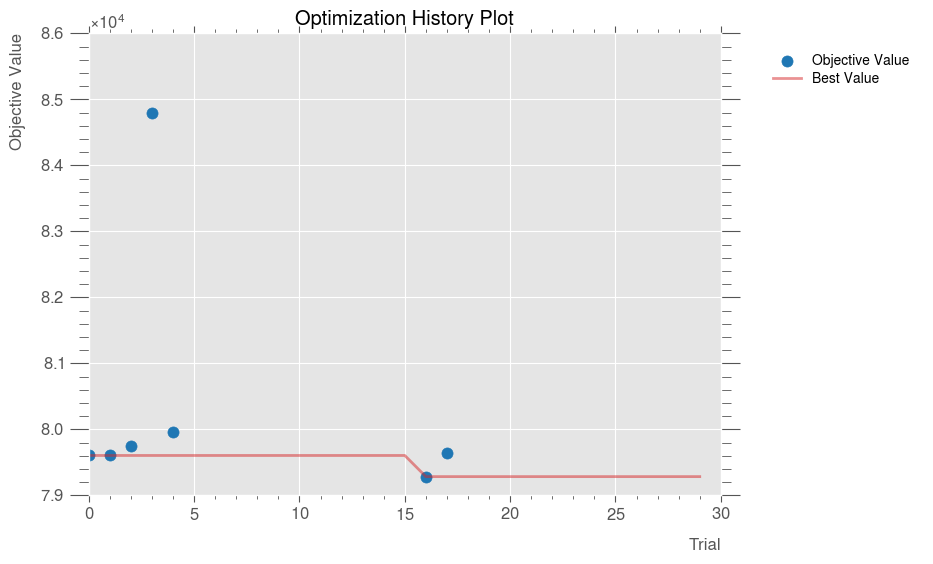

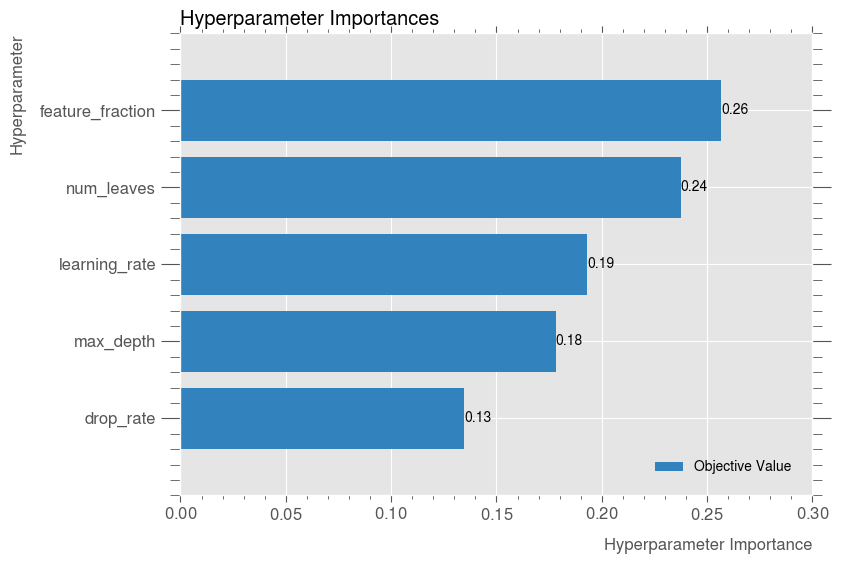

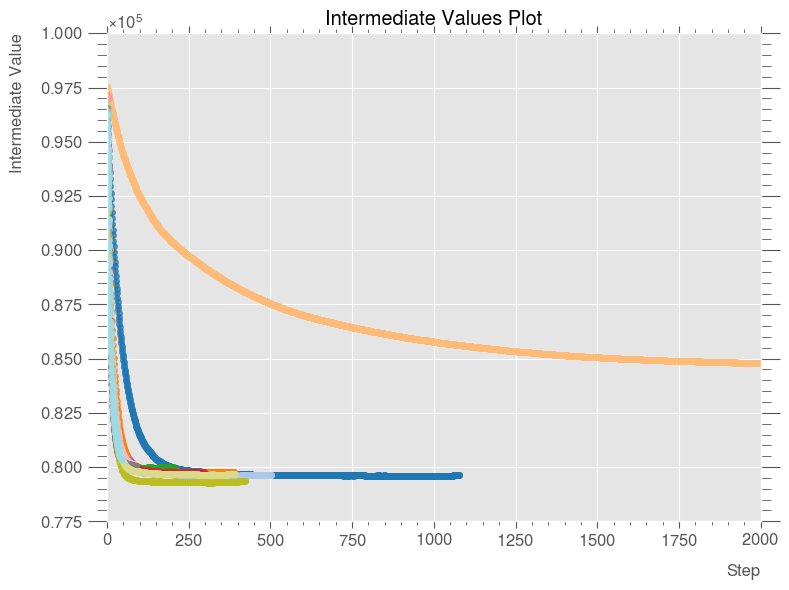

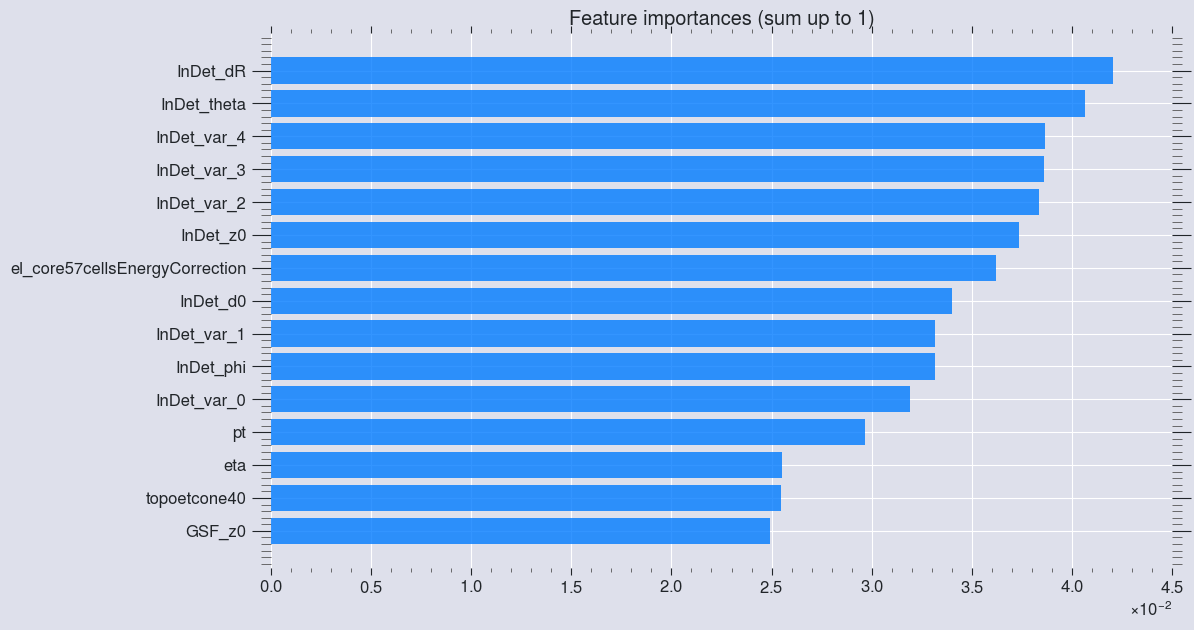


     . Optuna hyperparameters optimization finished
     .. Best trial number:16    |     mae:            79283.10500012698
 ---------------------------------------------------------------------------

Time elapsed for fit execution: 3 min 28.628 sec


In [14]:
tuner = RapidGBMTuner(metric='mae', trials=30, refit=True, verbosity=1, visualization=True, seed=414243)#, grid='h,learning_rate')

tuner.grid['max_depth'] = (0, 100)
tuner.grid['learning_rate'] = (0.00001, 0.1)
tuner.grid['drop_rate'] = (0.05,0.4)
# Fit tuner for each set of input_data
tuner.fit(X_train, y_train)

In [15]:
plt.rcdefaults()
hep.style.use([hep.style.ATLAS])

# Plot the learning curve
predictions = tuner.predict(X_test)

Mean Squared Error: 27957053415.70931
Mean Squared Error on training data: 24958314788.089214


Text(0, 1, 'Predicted Energy')

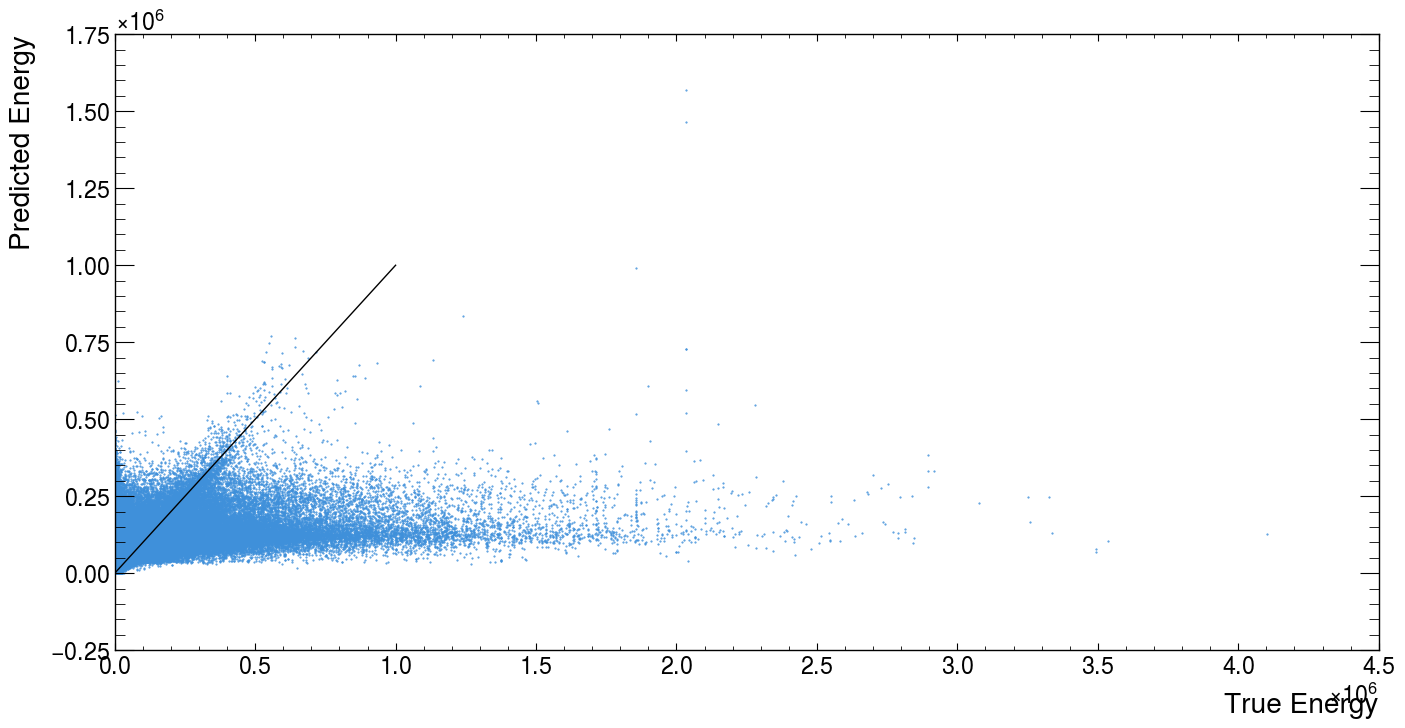

In [22]:
# evaluate the model
mae = mean_squared_error(y_test, predictions)

print(f'Mean Squared Error: {mae}')

mae_cheat = mean_squared_error(X_train_full['truthel_E'], tuner.predict(X_train))
print(f'Mean Squared Error on training data: {mae_cheat}')

fig, ax = plt.subplots(figsize=(16,8))
ax.plot(y_test, predictions, '.',markersize=1, label='Predicted vs True Energy')
ax.plot([0, 1e6], [0, 1e6], 'k-', lw=1, label='Ideal Prediction')

ax.set_xlabel('True Energy')
ax.set_ylabel('Predicted Energy')


- Shit at high energy, maybe we do a cut? (two models perhaps cut in meassured energy)

In [23]:
data = pd.concat([data1, data2, data3])
high_pt_data = data[(data['pt'] >= 9000)]
low_pt_data = data[(data['pt'] < 9000)]


 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 30 trials
     .. Evaluation metric: mae 
     .. Study direction: minimize mae

     . Trial number: 0 finished
     .. Optimization score (lower-better): mae: 17287.866965587644
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): mae: 17985.163862943464
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): mae: 17092.39399623355
 ...........................................................................
     . Trial number: 3 finished
     .. Optimization score (lower-better): mae: 23562.430941464838
 ...........................................................................
     . Trial number: 4 finished
     .. Optimization score (lower-better): mae: 18237.251031966785
 .......................................................

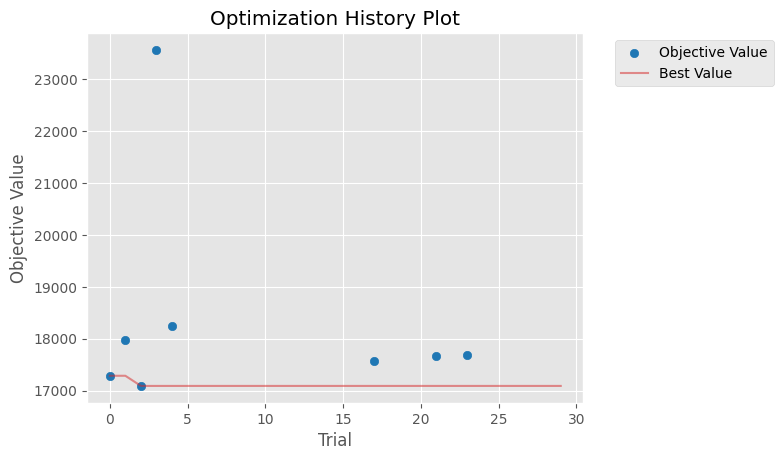

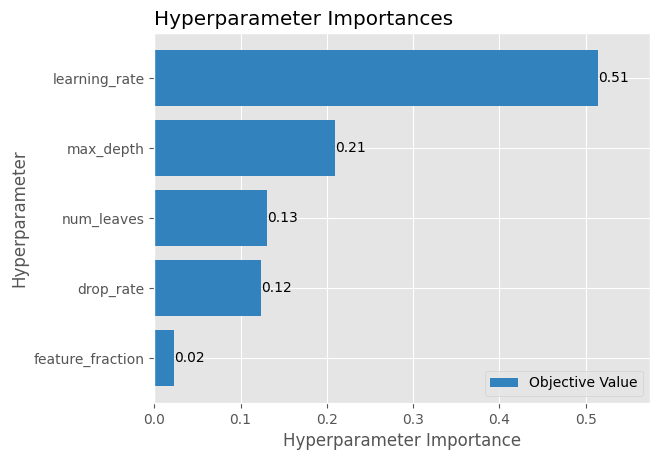

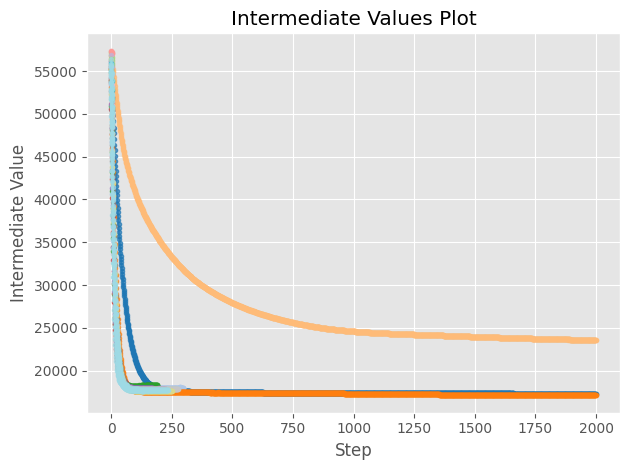

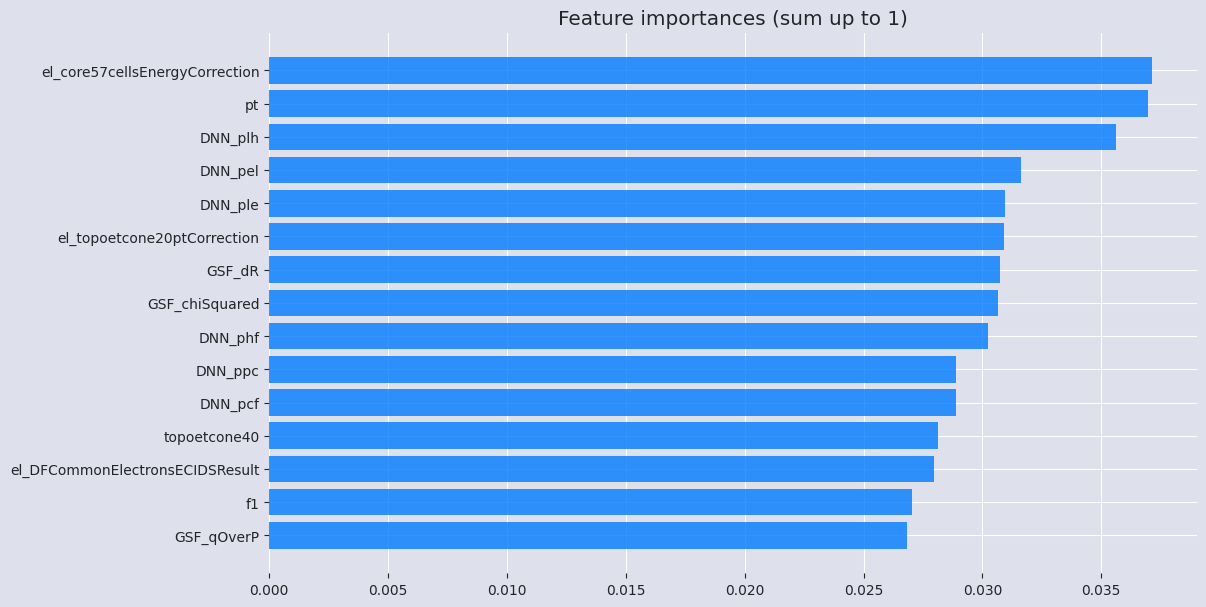


     . Optuna hyperparameters optimization finished
     .. Best trial number: 2    |     mae:            17092.39399623355
 ---------------------------------------------------------------------------

Time elapsed for fit execution: 3 min 47.742 sec


In [34]:
X_train, X_test, y_train, y_test = train_test_split(high_pt_data, high_pt_data['truthel_e_dressed'], test_size=0.2, random_state=12)

X_train_full = X_train.copy()
X_test_full = X_test.copy()
X_train.drop(drop_list, axis=1, inplace=True)
X_test.drop(drop_list, axis=1, inplace=True)

tuner = RapidGBMTuner(metric='mae', trials=30, refit=True, verbosity=1, visualization=True, seed=414243)#, grid='h,learning_rate')

tuner.grid['max_depth'] = (0, 100)
tuner.grid['learning_rate'] = (0.00001, 0.1)
tuner.grid['drop_rate'] = (0.05,0.4)

tuner.fit(X_train, y_train)

Text(0, 0.5, 'Predicted Energy')

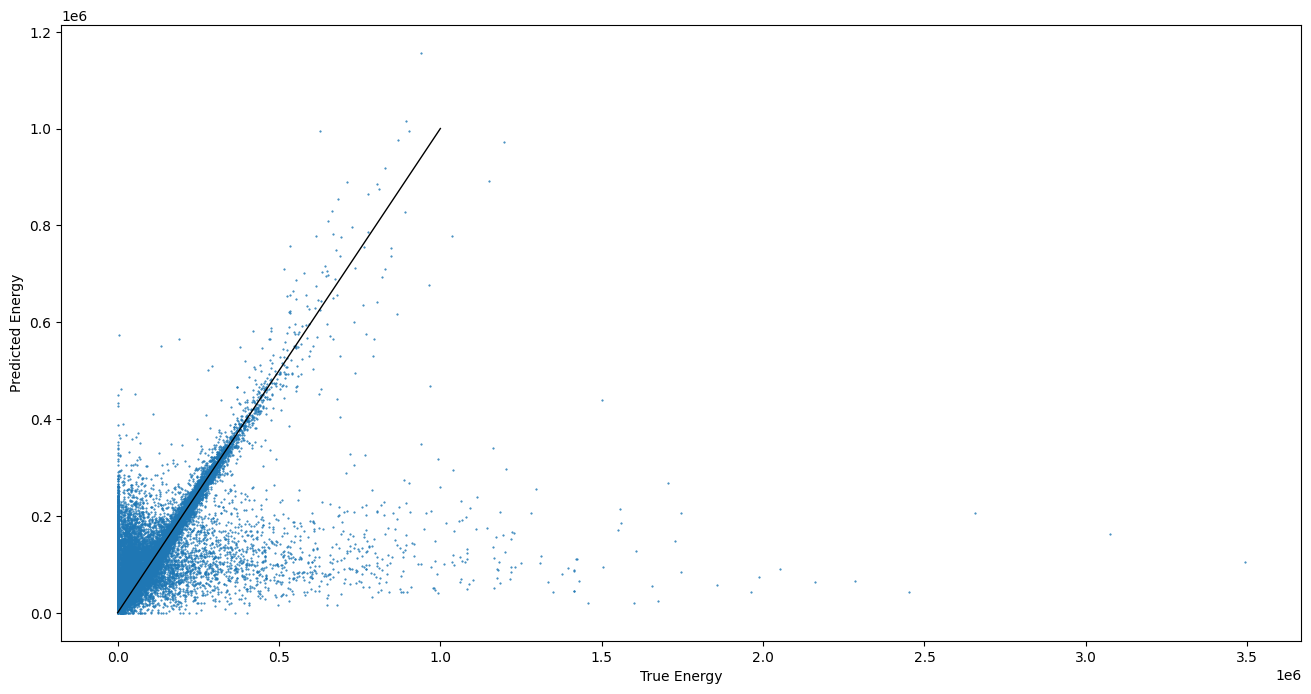

In [58]:
plt.rcdefaults()
x = np.linspace(0, 1e6, 1000)
predictions_high_pt = tuner.predict(X_test)
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(y_test, predictions_high_pt, '.',markersize=1, label='Predicted vs True Energy')
ax.plot(x, x, 'k-', lw=1, label='Ideal Prediction')
ax.set_xlabel('True Energy')
ax.set_ylabel('Predicted Energy')
# ax.set_yscale('log')
# ax.set_xscale('log')


In [46]:
print(X_test_full.columns)

Index(['runNumber', 'eventNumber', 'mcEventNumber', 'el_index', 'pt', 'eta',
       'phi', 'charge', 'm', 'f1', 'DNN_pel', 'DNN_pcf', 'DNN_ppc', 'DNN_phf',
       'DNN_ple', 'DNN_plh', 'el_firstEgMotherTruthType',
       'el_firstEgMotherTruthOrigin', 'el_DFCommonElectronsECIDS',
       'el_DFCommonElectronsECIDSResult', 'GSF_dR', 'GSF_d0', 'GSF_z0',
       'GSF_theta', 'GSF_phi', 'GSF_qOverP', 'GSF_chiSquared', 'GSF_var_0',
       'GSF_var_1', 'GSF_var_2', 'GSF_var_3', 'GSF_var_4', 'InDet_dR',
       'InDet_d0', 'InDet_z0', 'InDet_theta', 'InDet_phi', 'InDet_var_0',
       'InDet_var_1', 'InDet_var_2', 'InDet_var_3', 'InDet_var_4',
       'ptvarcone20', 'topoetcone20', 'topoetcone40', 'truthType',
       'truthOrigin', 'neflowisol20',
       'el_ptvarcone30_Nonprompt_All_MaxWeightTTVALooseCone_pt1000',
       'el_ptcone20_Nonprompt_All_MaxWeightTTVALooseCone_pt1000',
       'el_ptvarcone30_Nonprompt_All_MaxWeightTTVALooseCone_pt1000_CloseByCorr',
       'el_topoetcone20_CloseByCorr',


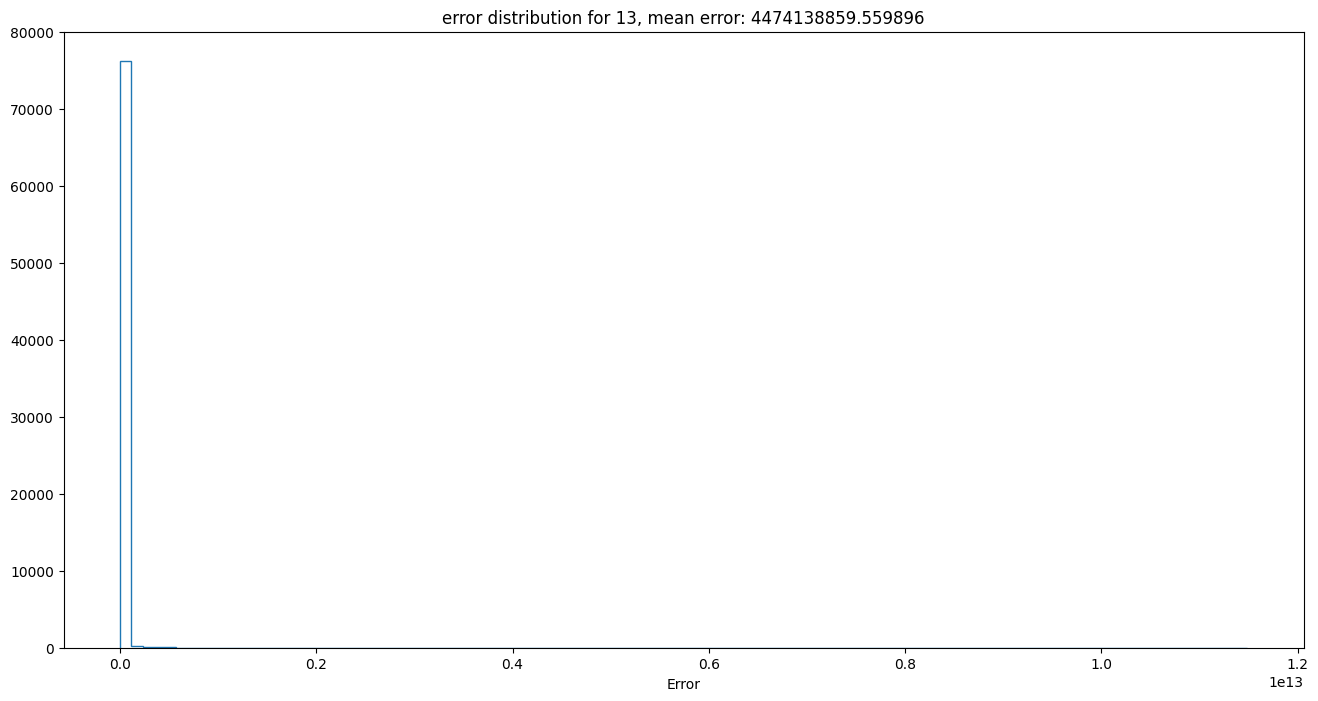

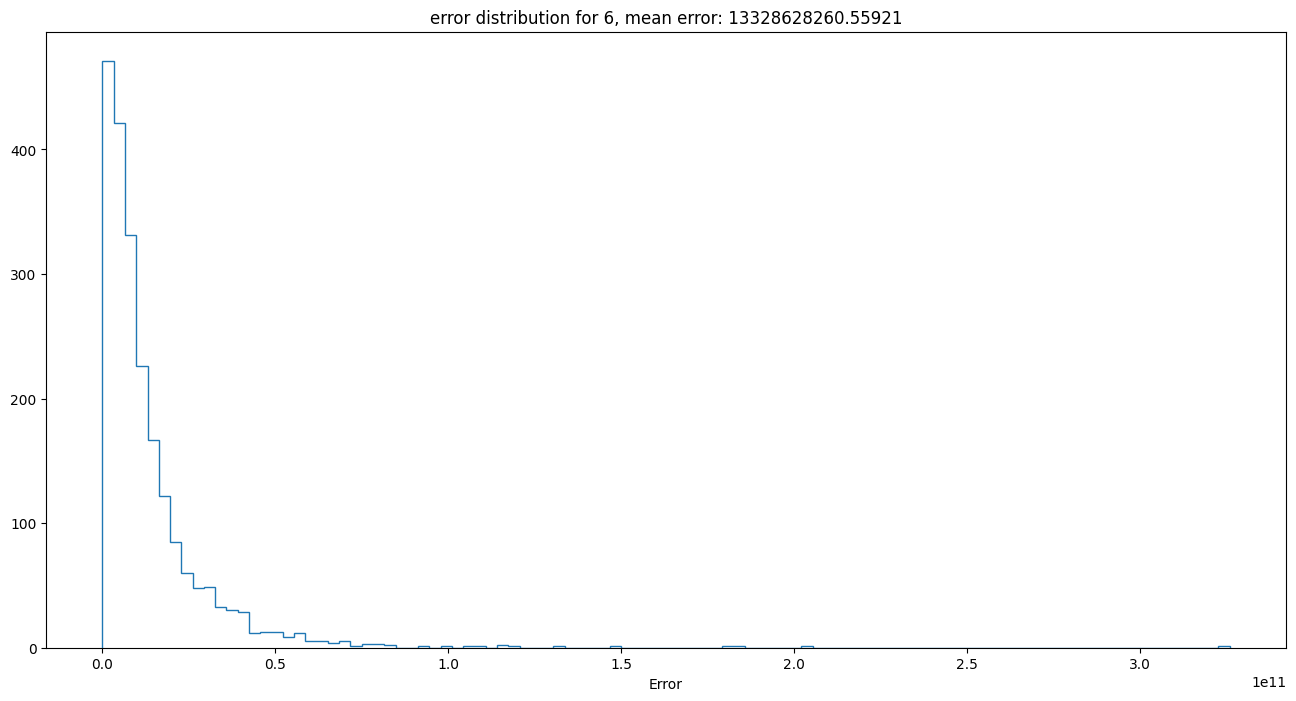

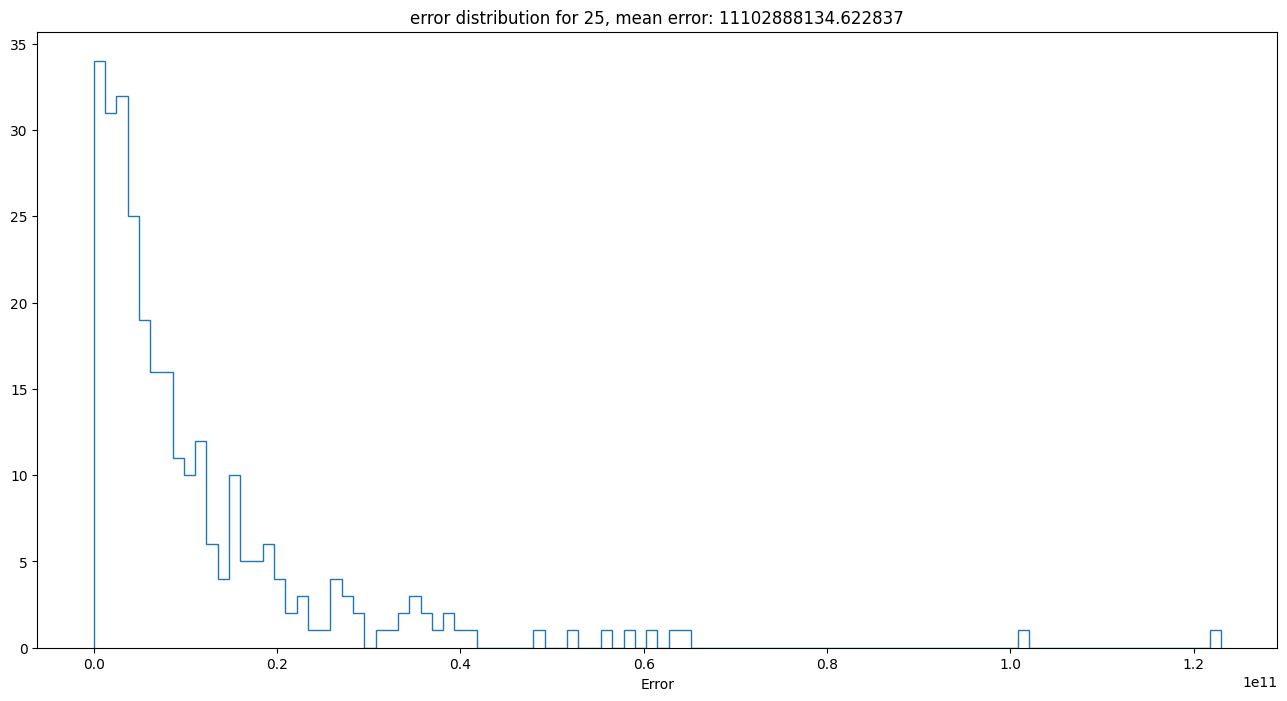

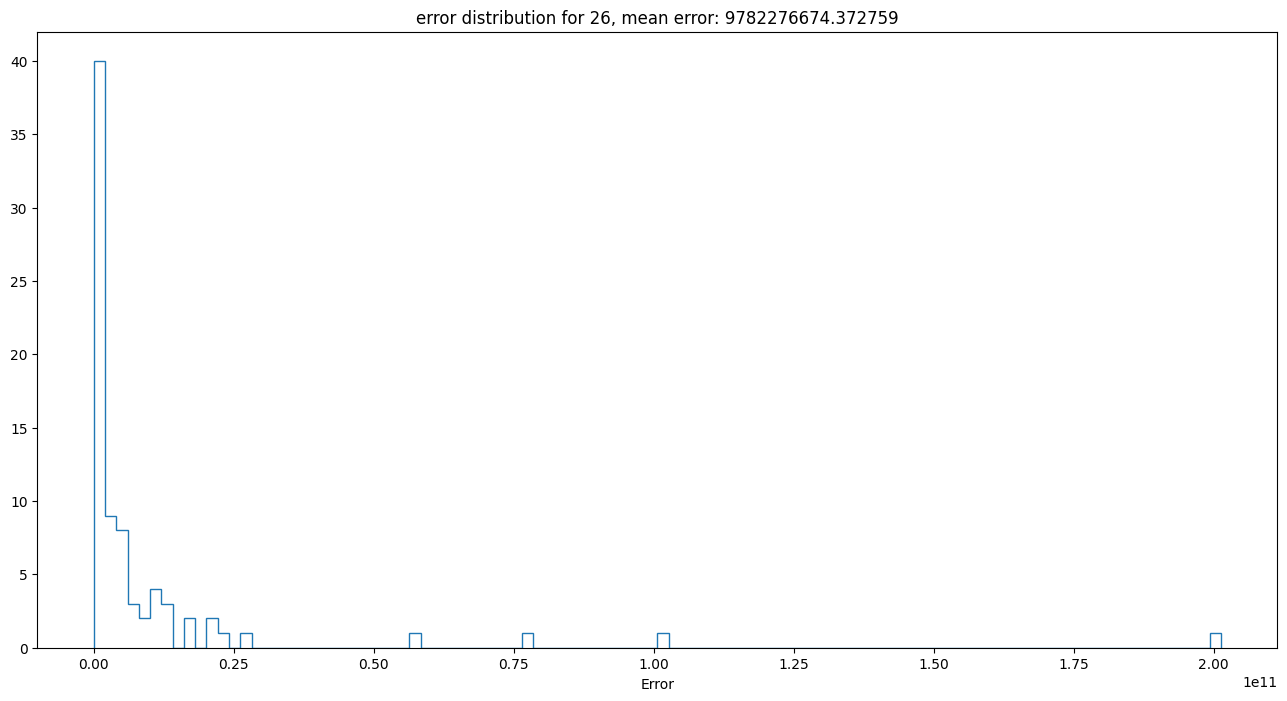

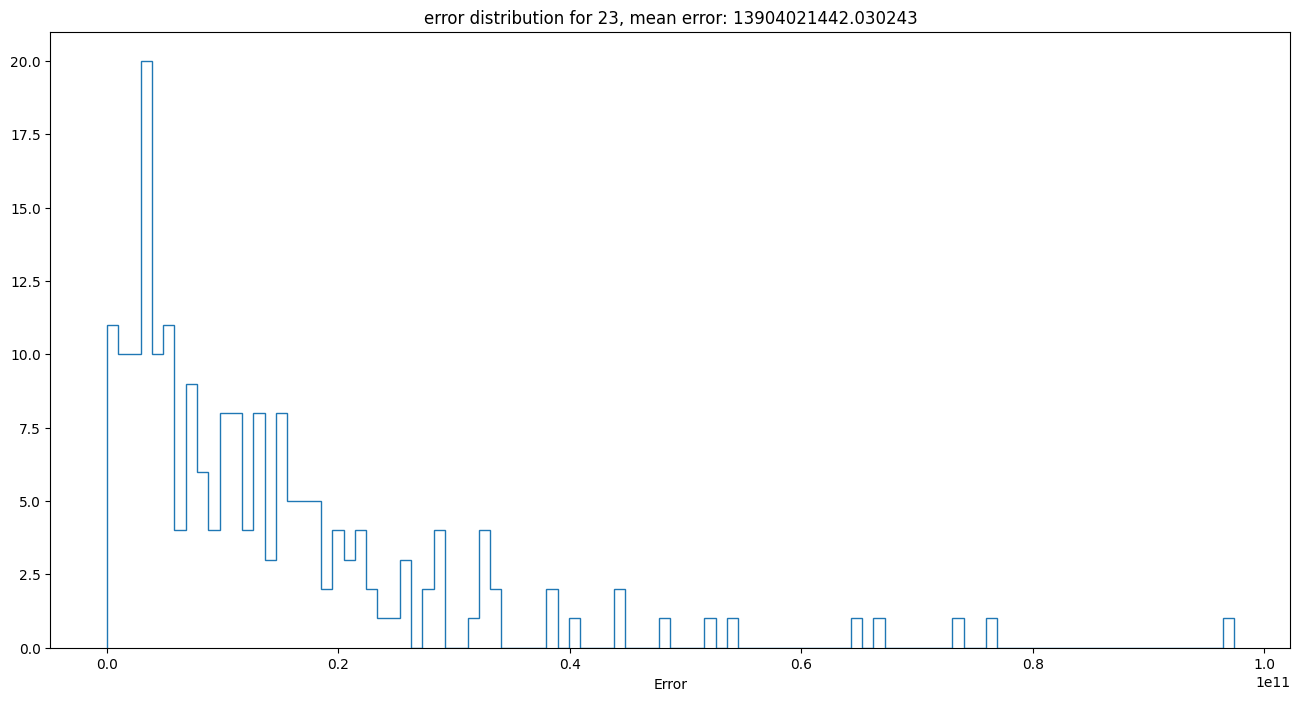

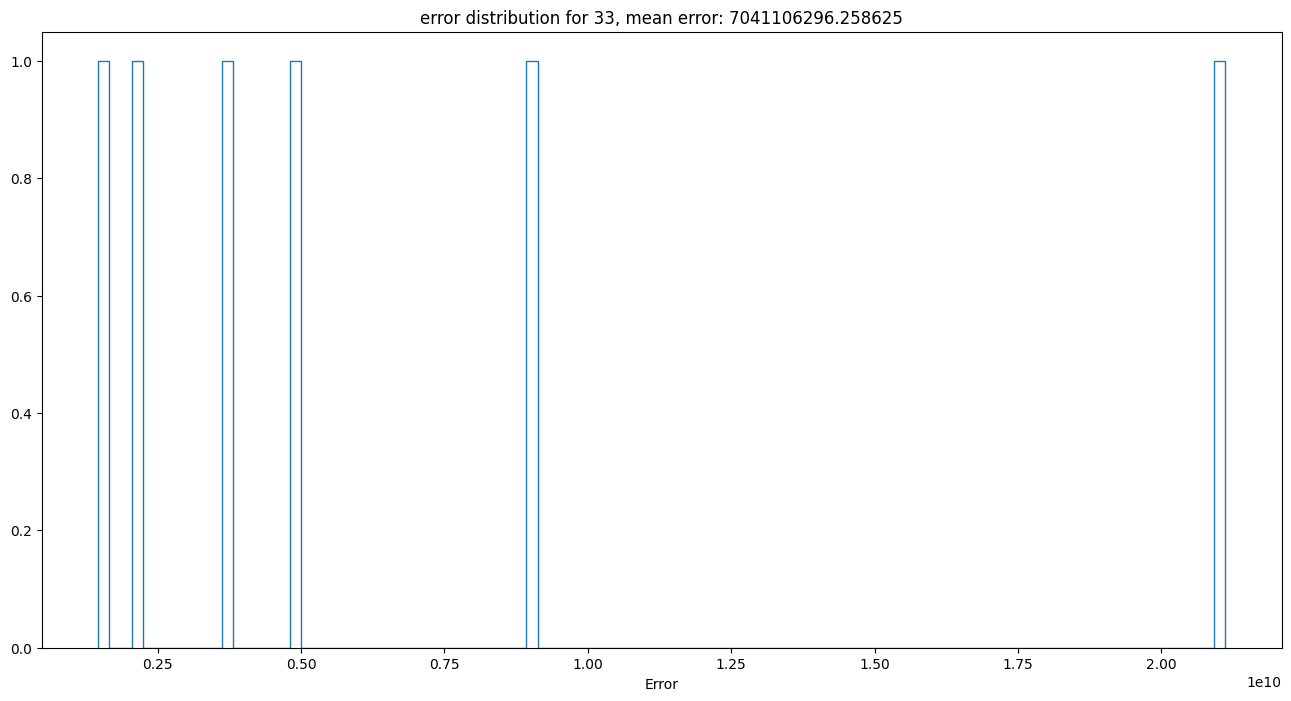

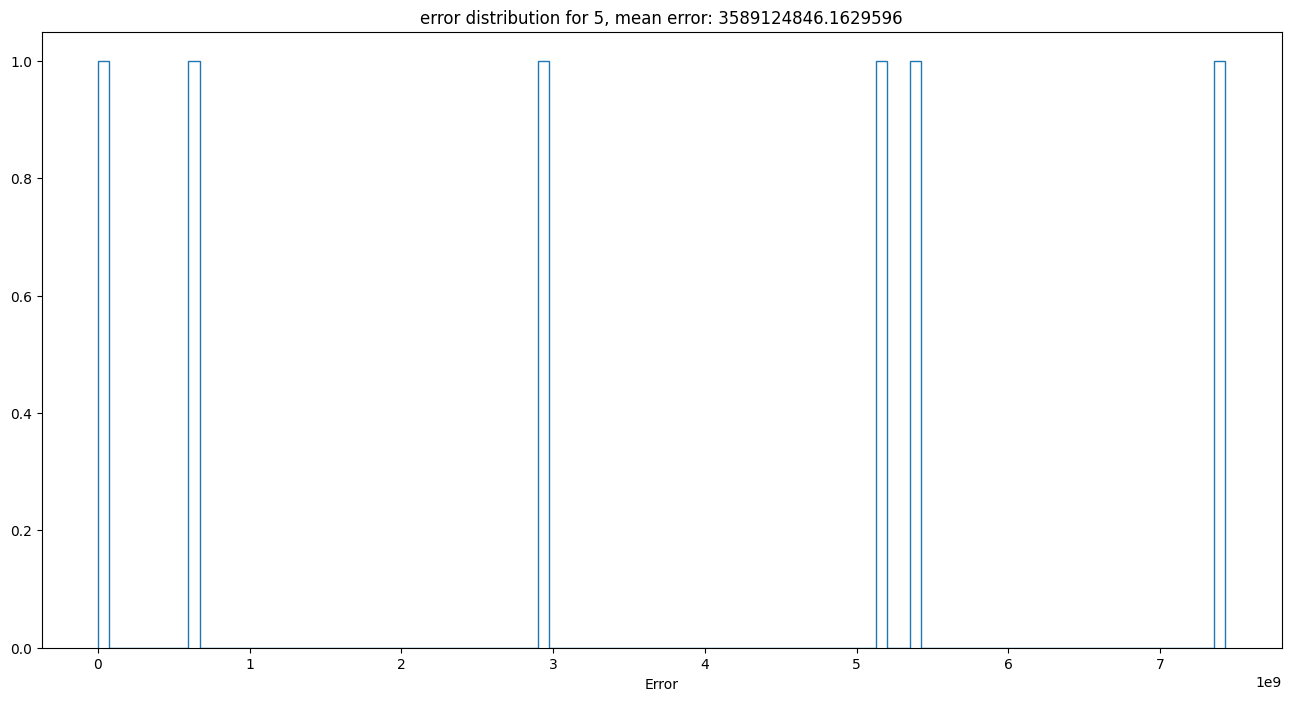

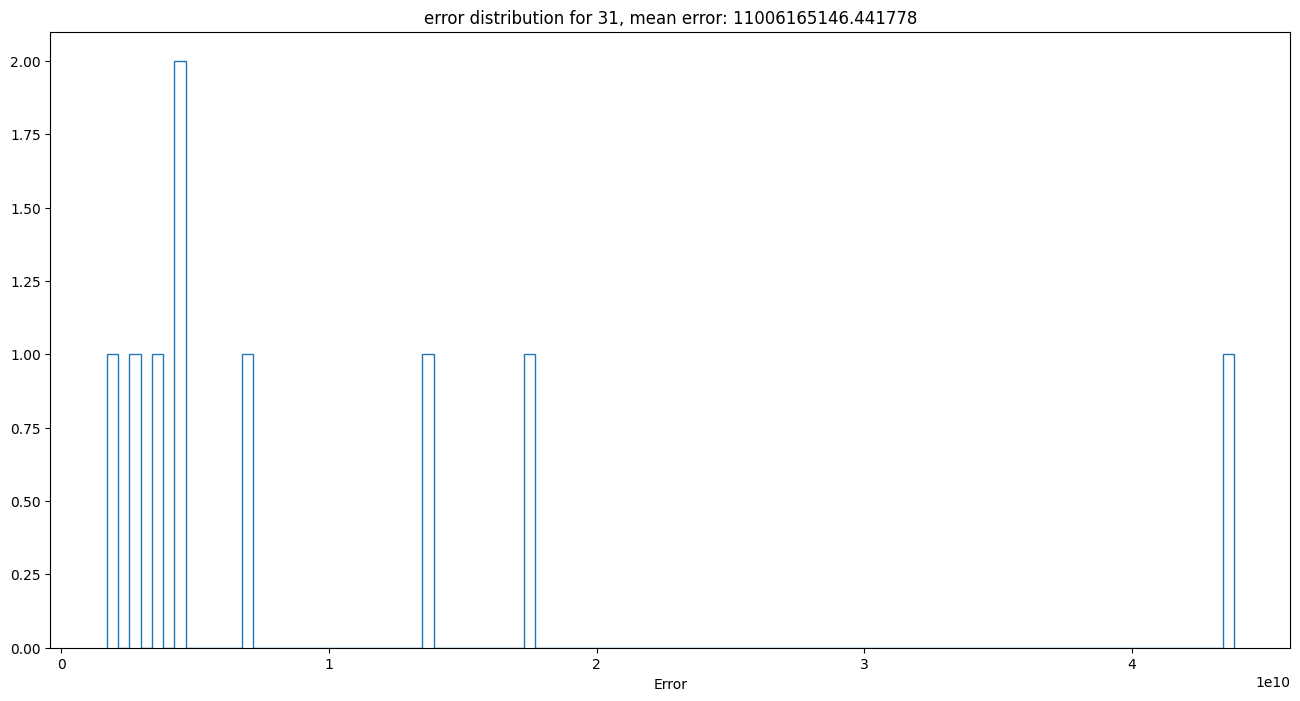

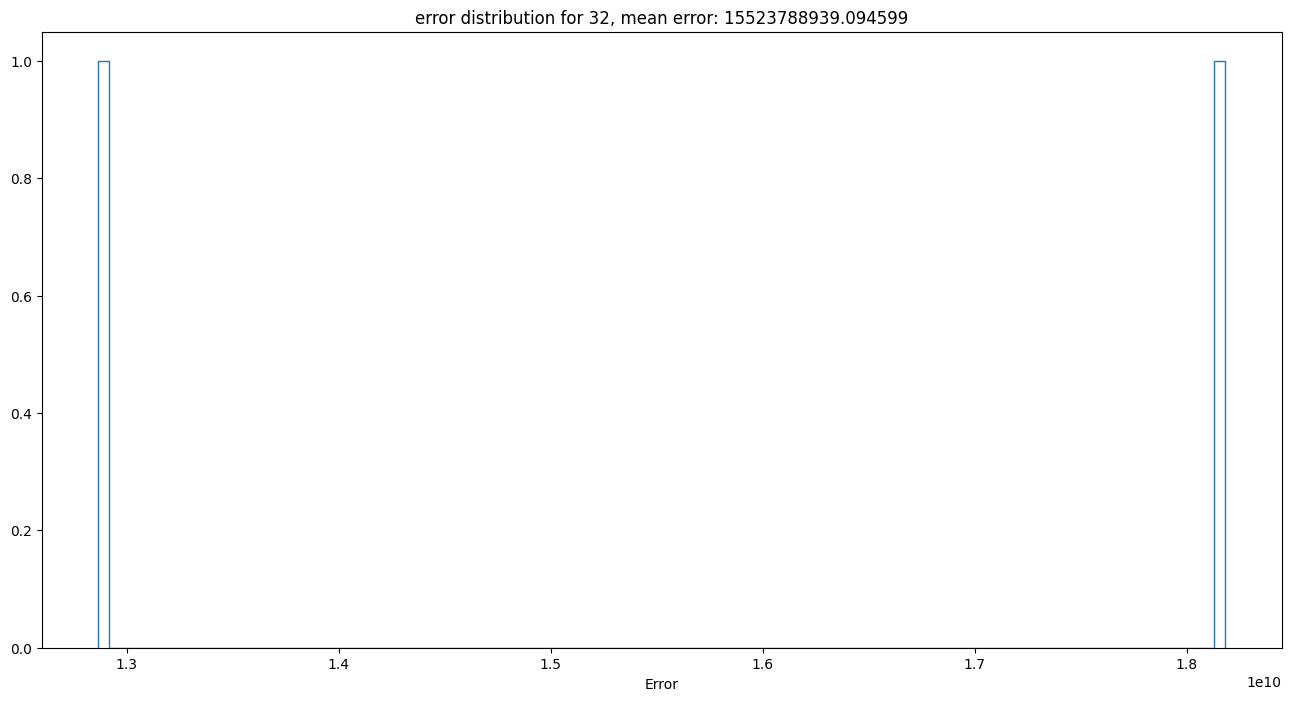

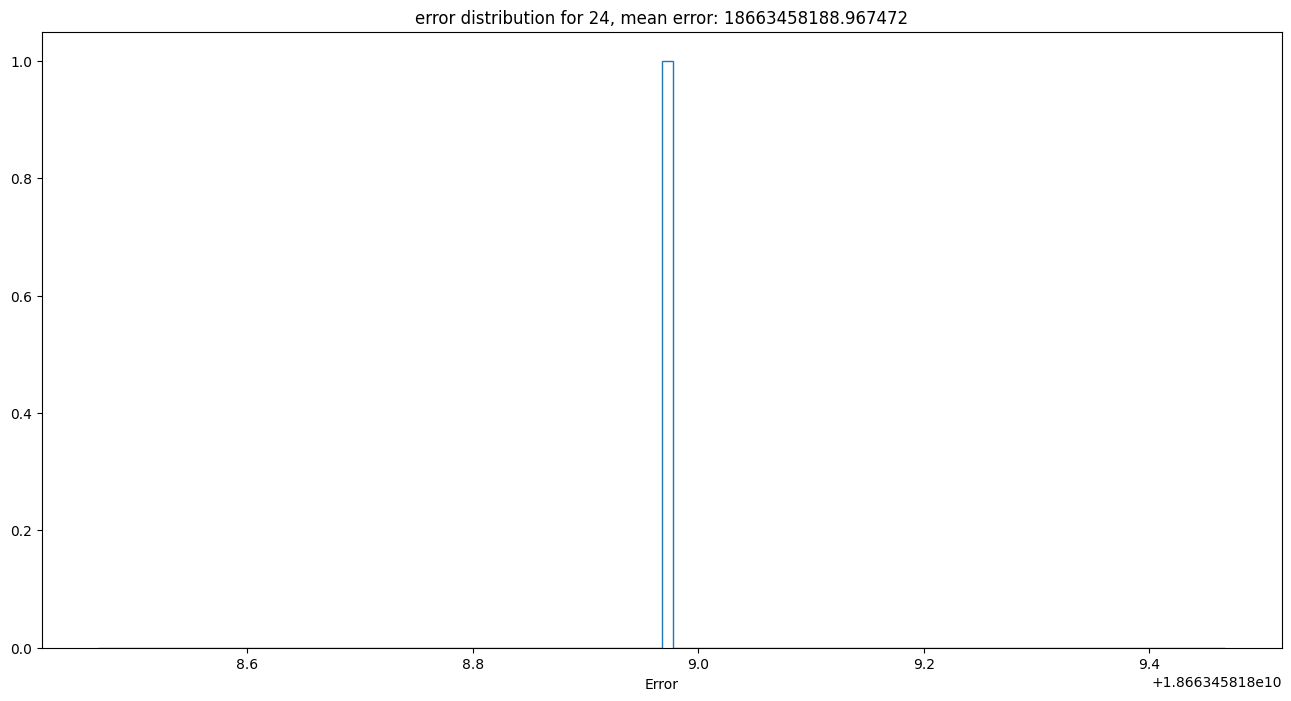

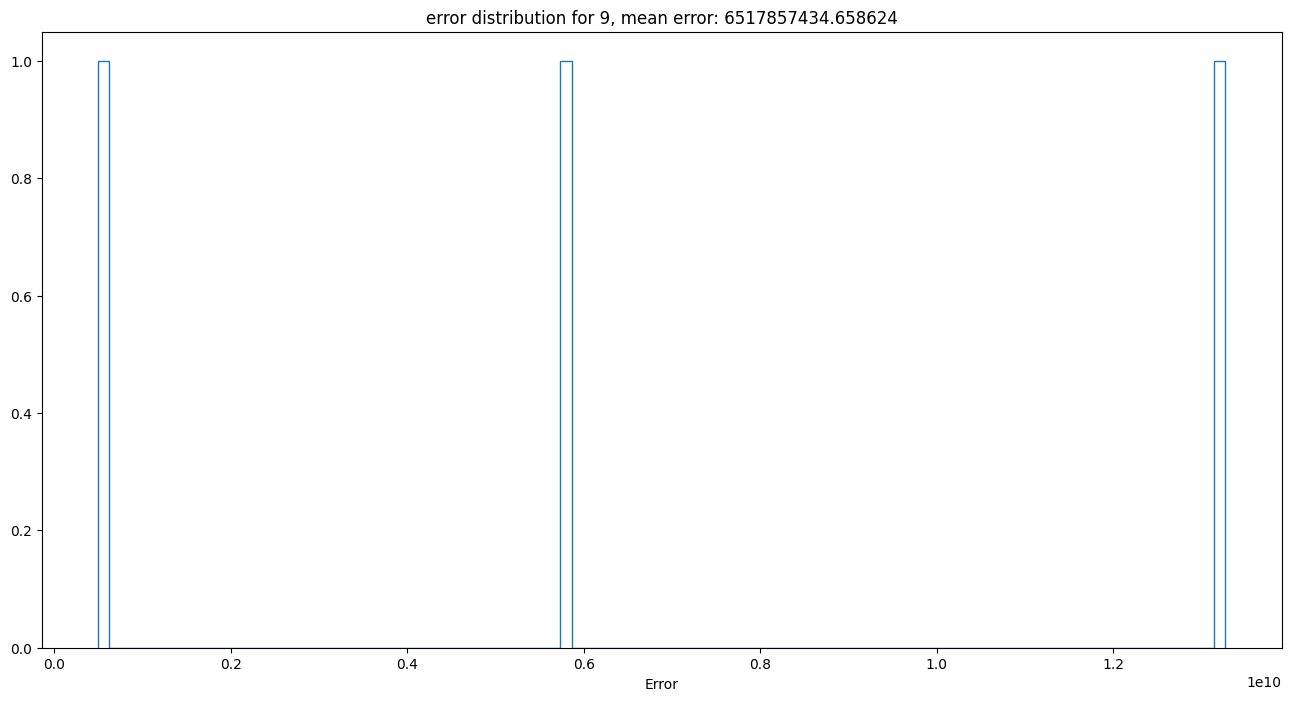

In [57]:
error = (predictions_high_pt - y_test)**2

# print(X_test_full['truthel_ParticleOrigin'].unique())
origin = X_test_full['truthel_ParticleOrigin'].unique()
for i in range(len(origin)):
    fig, ax = plt.subplots(figsize=(16,8))
    ax.hist(error[X_test_full['truthel_ParticleOrigin'] == origin[i]], bins=100, histtype='step', label=origin[i])
    ax.set_xlabel('Error')
    ax.set_title(f'error distribution for {origin[i]}, mean error: {np.mean(error[X_test_full["truthel_ParticleOrigin"] == origin[i]])}')
    